In [51]:
"llama3b" "sft_llama3b" "llama8b" "sft_llama8b" "qwen3b" "sft_qwen3b" "qwen7b" "sft_qwen7b" "leolm_mistral7b" "sft_leolm_mistral7b" "mistral7b" "sft_mistral7b"

'llama3bsft_llama3bllama8bsft_llama8bqwen3bsft_qwen3bqwen7bsft_qwen7bleolm_mistral7bsft_leolm_mistral7bmistral7bsft_mistral7b'

In [62]:
%load_ext autoreload
%autoreload 2

import os
import re
import statistics

folder_path = "C:/Users/HP/Documents/GitHub/thesis_staging/outputs/"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        if 'sft' in filename:
            new_filename = filename.replace('bs4', 'bs25')
            new_file_path = os.path.join(folder_path, new_filename)
            #if os.path.exists(new_file_path):
            #    os.remove(new_file_path)
            #os.rename(file_path, new_file_path)
            print(f"Renamed: {filename} -> {new_filename}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Renamed: sft_dev.jsonl -> sft_dev.jsonl


In [12]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt
from utils import base_dependencies
import matplotlib.pyplot as plt|
import seaborn as sns
from cycler import cycler
import numpy as np

def sft_progression(type, model_or_paramix, checkpoint_span):

    folder_path = f'outputs/sft_dev_eval/'
    df_dict = {}

    metrics = ["bert", "bleu", "sari", "ease", "wstf", "leng", "equl", "loss", ] # "empt", "lang", "lens", "bert_sd", "wstf_sd", "sari_sd"
    for metric in metrics:

        data = {}

        # Loop through each file in the folder
        for filename in os.listdir(folder_path):

            if type == 'cross_model':
                if (model_or_paramix + '_sft' not in filename and '__' + model_or_paramix not in filename) or metric.replace('sd','') not in filename:
                    continue
            if type == 'cross_paramix':
                if ('sft_' + model_or_paramix not in filename and '__' + model_or_paramix not in filename) or metric.replace('sd','') not in filename:
                    continue

            if "sft" in filename:
                # extract model and # train observations
                model = 'sft_' + filename.split('sft_')[1].split('_checkpoint')[0]
                checkpoint = int(filename.split('_checkpoint')[1].replace('.txt', ''))
                paramix = 'bs' + filename.split('bs', maxsplit=1)[1].split('_')[0]
            elif "sft" not in filename:
                model = filename.split('__', maxsplit=1)[1].split('.txt')[0]
                checkpoint = checkpoint_span
                paramix = "base"
               
            # extract score
            with open(os.path.join(folder_path, filename), 'r') as f:
                content = f.read().strip()
                try:
                    score = ast.literal_eval(content)
                except ValueError:
                    score = float(content)

            if metric == 'bert':
                score = sum(score['f1']) / len(score['f1'])
            if metric == 'bert_sd':
                score = statistics.stdev(score['f1'])
            if metric == 'bleu':
                score = score['bleu']
            if metric == 'lens' or metric== 'ease' or metric == 'wstf':
                score = sum(score) / len(score)
            if metric == 'wstf_sd':
                score = statistics.stdev(score)
            if metric == 'sari':
                score = score['sari']
            if metric == 'sari_sd':
                score = score['sari'].std()
            

            if type == 'cross_paramix':
                if paramix not in data:
                    data[paramix] = {}
                data[paramix][checkpoint] = score  
            elif type == 'cross_model':
                if model not in data:
                    data[model] = {}
                data[model][checkpoint] = score

        df = pd.DataFrame.from_dict(data, orient='index').sort_index(axis=0).sort_index(axis=1)

        df = df.T.reset_index()
        df = df[df['index'] % checkpoint_span == 0]
        df = df.interpolate(method='ffill')
        df_dict[metric] = df
        
    return df_dict

def return_visual_element(element, i):
    colors = sns.color_palette("colorblind", 11)
    linestyles = ["-", "--", ":", "-.", (0, (3, 1, 1, 1)), (0, (5, 2, 2, 2)), 
              (0, (1, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1, 1, 1)), 
              (0, (5, 2, 2, 2, 2, 2)), (0, (3, 3, 1, 1))]
    markers = ["o", "s", "^", "D", "v", "p", "h", "X", "*", "P", "+"]
    if element == 'color':
        if i == 0: # disco
            return base_dependencies.return_model_color('disco')
        elif i == 1: # leo mistral
            return base_dependencies.return_model_color('leolm')
        elif i == 2: # llama
            return base_dependencies.return_model_color('llama')
        elif i == 3: # mistral
            return base_dependencies.return_model_color('mistral')
        #return colors[i]
    if element == 'linestyle':
        return linestyles[i]
    if element == 'marker':
        return markers[i]
    
def generate_from_key(key, label_or_color_or_linestyle):
    import re
    match = re.match(r'bs(\d+)ga(\d+)dv(\d+)lr([\de.-]+)', key)
    if match:
        bs, ga, dv, lr = map(float, match.groups())
        ebs = int(bs * ga * dv)
        if label_or_color_or_linestyle == 'label':
            return f"EBS {ebs}, LR {lr}"
        if key == 'bs16ga1dv1lr1e-4':
            idx = 0
        if key == 'bs16ga1dv1lr5e-5':
            idx = 1
        if key == 'bs16ga1dv1lr1e-5':
            idx = 2
        if key == 'bs16ga2dv1lr1e-4':
            idx = 3
        if key == 'bs16ga2dv1lr5e-5':
            idx = 4
        if key == 'bs16ga2dv1lr1e-5':
            idx = 5
        if key == 'bs16ga4dv1lr1e-4':
            idx = 6
        if key == 'bs16ga4dv1lr5e-5':
            idx = 7
        if key == 'bs16ga4dv1lr1e-5':
            idx = 8
        return return_visual_element(label_or_color_or_linestyle, idx)

    else:
        if label_or_color_or_linestyle == 'label':
            if key == 'sft_disco_llama8b1':
                return base_dependencies.return_proper_model_name('disco') + r'$^{1}$'
            if key == 'sft_disco_llama8b2':
                return base_dependencies.return_proper_model_name('disco') + r'$^{2}$'
            if key == 'sft_leolm_mistral7b':
                return base_dependencies.return_proper_model_name('leolm') + r'$^{1}$'
            if key == 'sft_llama8b1':
                return base_dependencies.return_proper_model_name('llama') + r'$^{1}$'
            if key == 'sft_llama8b2':
                return base_dependencies.return_proper_model_name('llama') + r'$^{2}$'
            if key == 'sft_mistral7b':
                return base_dependencies.return_proper_model_name('mistral') + r'$^{1}$'
            
        elif label_or_color_or_linestyle == 'linestyle':
            if 'sft_disco_llama8b' in key:
                idx = 0
                if '2' in key:
                    idx = 1
            if key == 'sft_leolm_mistral7b':
                idx = 2
            if 'sft_llama8b' in key:
                idx = 3
                if '2' in key:
                    idx = 4
            if key == 'sft_mistral7b':
                idx = 5
            return return_visual_element(label_or_color_or_linestyle, idx)
        else:
            if 'sft_disco_llama8b' in key:
                idx = 0
            if key == 'sft_leolm_mistral7b':
                idx = 1
            if 'sft_llama8b' in key:
                idx = 2
            if key == 'sft_mistral7b':
                idx = 3
            return return_visual_element(label_or_color_or_linestyle, idx)
    

SyntaxError: invalid syntax (1386296294.py, line 8)

In [13]:
from matplotlib.gridspec import GridSpec


#plt.style.use('ggplot')
def plot_sft_progression(type, model_or_paramix, df_dict, rnge = 'free'):

    print(type)
    metrics = ["bert", "bleu", "sari", "leng", "ease", "wstf", "equl", "loss"] #"empt", "lang", "lens"
    
    plot_df_dict = df_dict.copy()
    for metric in plot_df_dict.keys():
        plot_df_dict[metric] = plot_df_dict[metric].loc[:, plot_df_dict[metric].columns.str.contains('bs|sft|index|base')]

    fig = plt.figure(figsize=(11, 11), constrained_layout=True)
    gs = GridSpec(3, 3, figure=fig, wspace = 0.4, hspace=0.5)
 
    #for i in range(len(metrics), len(axes)):  # Hide extra unused subplot
    #    fig.delaxes(axes[i])

    ylabsize = 10
    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(gs[i])
        ax.grid(True, axis='y')
        df = plot_df_dict[metric]
        x = df['index'].astype(int)
        for column in df.columns:
            if column != 'index':
                ax.plot(x, df[column], label=generate_from_key(column, 'label'), color=generate_from_key(column, 'color'), linestyle=generate_from_key(column, 'linestyle'), marker=generate_from_key(column, 'marker'))
        if metric == 'bert':
            ax.set_ylabel(r'Avg. Compl.$\rightarrow$Simp. BERTScore F1', fontsize = ylabsize)
        if metric == 'bleu':
            ax.set_ylabel(r'Avg. Compl.$\rightarrow$Simp. BLEU Score', fontsize = ylabsize)
        if metric == 'sari':
            ax.set_ylabel(r'Avg. Compl.$\rightarrow$Simp. SARI Score', fontsize = ylabsize)
        if metric == 'ease':
            ax.set_ylabel('Avg. Simp. Flesch Reading Ease', fontsize = ylabsize)
        if metric == 'empt':
            ax.set_ylabel('Prop. Simp. Empty (< 10 char)', fontsize = ylabsize)
        if metric == 'equl':
            ax.set_ylabel('Prop. Simp. Equal to Complex', fontsize = ylabsize)
        if metric == 'wstf':
            ax.set_ylabel(r'Avg. Simp. $\text{WSTF}_4$', fontsize = ylabsize)
        if metric == 'lang':
            ax.set_ylabel('Prop. Simp. Classified as German', fontsize = ylabsize)
        if metric == 'leng':
            ax.set_ylabel('Avg. Word Count of Simp.', fontsize = ylabsize)
        if metric == 'loss':
            ax.set_ylabel('Cross-Entropy Loss', fontsize = ylabsize)
        if metric == 'lens':
            ax.set_ylabel('Avg. LENS Simp. Rating', fontsize = ylabsize)
        ax.set_xlabel('Training Instances', fontsize = ylabsize)

        #ax.set_ylabel('')

        #if i == 5:
        #    ax.text(0.5, -0.15, '* According to the Python library langdetect', ha='right', va='top', 
        #            transform=ax.transAxes, fontsize=10, style='italic')
        if rnge == 'reasonable':   
            if i == 0:
                ax.set_ylim(0.84, 0.95)
            if i == 1:
                ax.set_ylim(0.2, 0.65)
            if i == 2:
                ax.set_ylim(37, 47)
        if i == 6:
            ax.set_ylim(0, 0.25)
        #if i == 7:
        #    ax.set_ylim(0, 0.20)
        if i == 8:
            ax.set_ylim(0.95,1)
        if i == -1:
            ax.legend(loc='lower right', frameon=True)   
        if i == -1:
            ax.legend(loc='upper right', frameon=True)   
        if i == -1:
            ax.legend(loc='upper right', frameon=True)     

        # ax.axvline(x=3000, color='gray', linestyle=':', linewidth=2)
        ax.set_xticks(range(0, 3601, 400))
        ax.tick_params(axis='both', labelsize=ylabsize-2)
        ax.set_xticklabels(ax.get_xticks(), rotation=90)
    # fig.text(0.5, 0.01, 'The dashed vertical line indicates the training step when we save a LLaMA 8B Instruct checkpoint for DPO.', ha='center', va='top', fontsize=10)

    if 'bs' in model_or_paramix:
        bs, ga_steps, gpu_count, lr = base_dependencies.paramix_parser(model_or_paramix)
        title = f'EBS{bs*ga_steps*gpu_count}, {lr}'
    if model_or_paramix == 'bs16ga1dv1lr1e-4':
        title = 'SFT Cross-Model Comparison'

    if model_or_paramix == 'disco_llama8b':
        title = 'Disco Llama 8B'

    if type == 'cross_paramix':
        if model_or_paramix == 'disco_llama8b':
            title = "Parameter Mix Grid Search: DiscoLeo Llama 8B"

    #fig.suptitle(title, fontsize=20, y=1.06)
    if type == 'cross_paramix':
        fig.legend(handles=ax.get_legend_handles_labels()[0], labels=ax.get_legend_handles_labels()[1], loc="upper center", ncol=1, fontsize=10, frameon=True, bbox_to_anchor=(0.79, 0.28))
        plt.tight_layout()
        plt.savefig('figures/results_sft_paramix.png', dpi=800) 
    if type == 'cross_model':
        fig.legend(handles=ax.get_legend_handles_labels()[0], labels=ax.get_legend_handles_labels()[1], loc="upper center", ncol=1, fontsize=10, frameon=True, bbox_to_anchor=(0.79, 0.28))
        plt.tight_layout()
        plt.savefig('figures/results_sft_modelmix.png', dpi=800) 
    #plt.subplots_adjust(top=0.80)

    #plt.subplots_adjust(hspace=0.4)

    #plt.show()

    
    #fig.delaxes(axes[10])
    #fig.delaxes(axes[8])
    #fig.delaxes(axes[7])

    #axes[7] = axes[9]
    
    

cross_model
bs16ga1dv1lr1e-4
16
1
1
1e-4


C:\Users\HP\AppData\Local\Temp\ipykernel_27376\3999789608.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_27376\3999789608.py:104: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


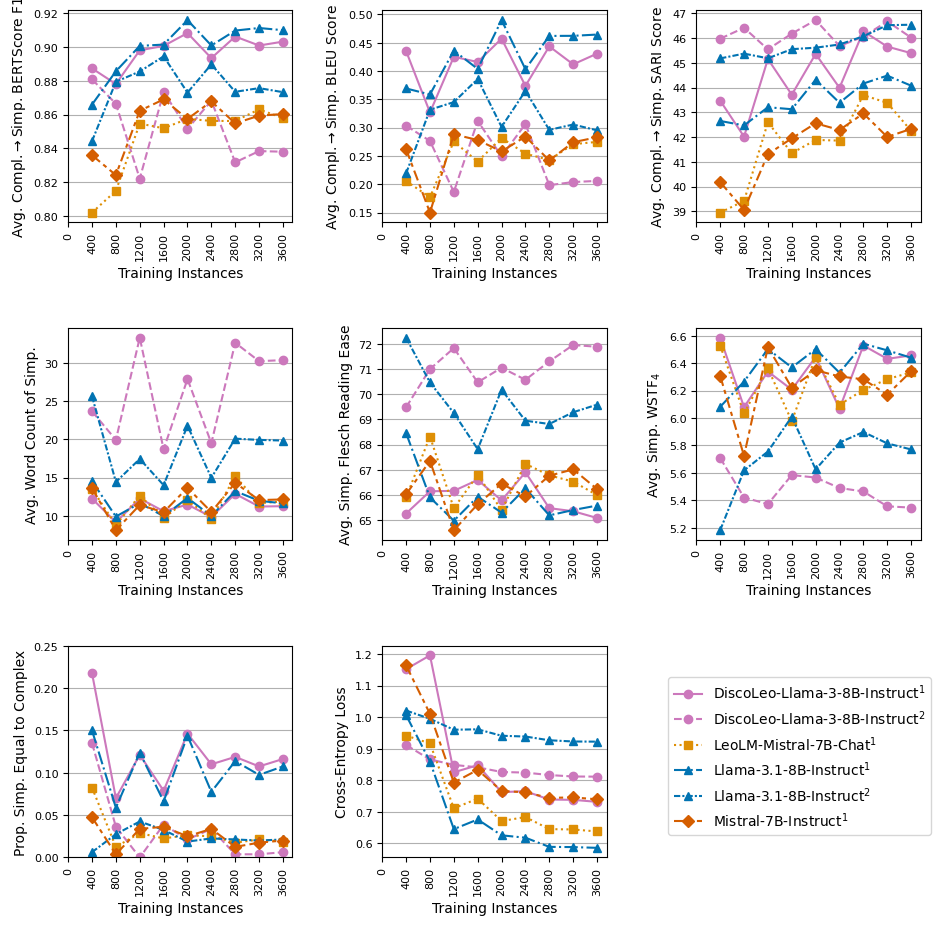

In [14]:
df_dict = sft_progression("cross_model", "bs16ga1dv1lr1e-4", 400)
#print(df_dict)
plot_sft_progression("cross_model", "bs16ga1dv1lr1e-4", df_dict)

cross_paramix


C:\Users\HP\AppData\Local\Temp\ipykernel_27376\3999789608.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_27376\3999789608.py:100: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


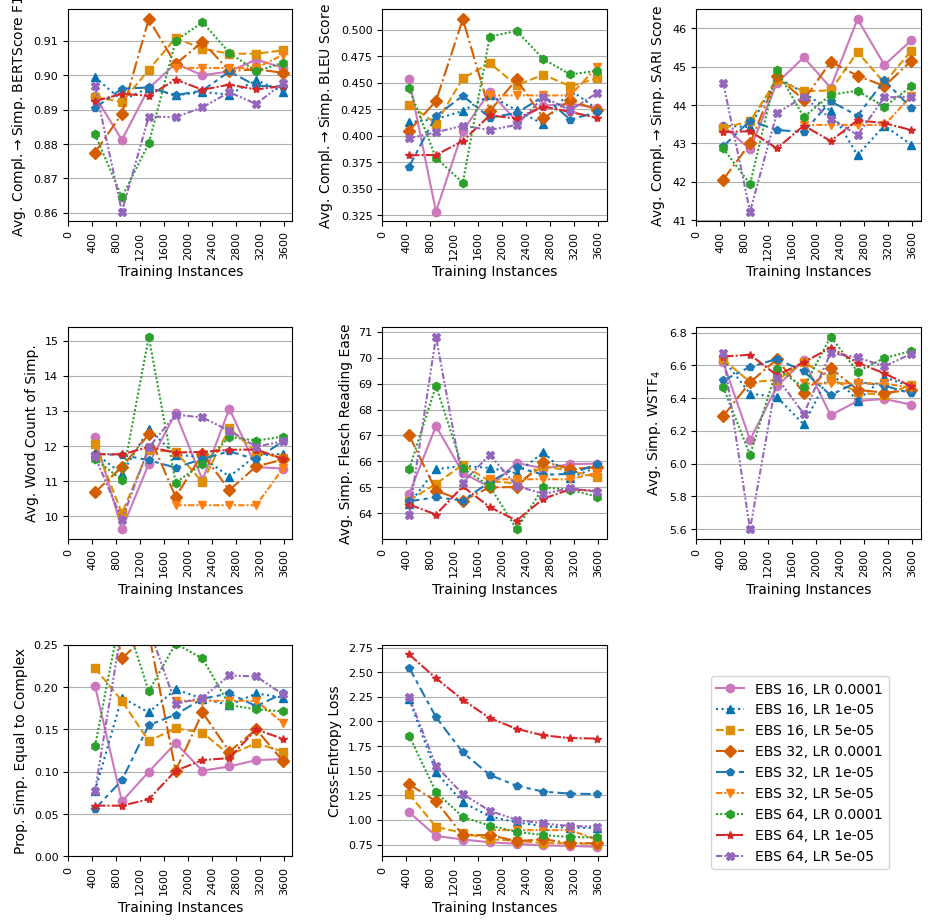

In [15]:
df_dict = sft_progression("cross_paramix", "disco_llama8b", 448)
#print(df_dict)
plot_sft_progression("cross_paramix", "disco_llama8b", df_dict)

#### final eval (dpo compared to sft on certain automatic metrics)

In [79]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt
from utils import base_dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import numpy as np

def final_eval_stats():

    folder_path = f'outputs/sft_test_eval/'
    df_dict = {}

    metrics = ["bert", "bert_sd", "bleu", "sari", "sari_sd", "ease", "wstf", "wstf_sd", "leng", "lang", "equl", "empt", "loss", "lens"] # "empt", "lang", "lens"
    for metric in metrics:
        data = {}
        # Loop through each file in the folder
        for filename in os.listdir(folder_path):
            if "dpo" in filename:
                # extract model and # train observations
                model = 'dpo_' + filename.split('sft_')[1].split('_checkpoint')[0]
                if '_ea' in filename:
                    model = model + '_ea'
                if '_ta' in filename:
                    model = model + '_ta'
            else:
                model = filename.split('sft_')[1].split('_checkpoint')[0]
                model = model + '_sft'
                
            # extract score
            with open(os.path.join(folder_path, filename), 'r') as f:
                content = f.read().strip()
                try:
                    score = ast.literal_eval(content)
                except ValueError:
                    score = float(content)
            if metric in filename or metric.replace('sd','') in filename:
                if metric == 'bert':
                    score = sum(score['f1']) / len(score['f1'])
                if metric == 'bert_sd':
                    score = statistics.stdev(score['f1'])
                if metric == 'bleu':
                    score = score['bleu']
                if metric == 'lens' or metric== 'ease' or metric == 'wstf':
                    score = sum(score) / len(score)
                if metric == 'wstf_sd':
                    score = statistics.stdev(score)
                if metric == 'sari':
                    score = score[0]['sari']
                if metric == 'sari_sd':
                    score = statistics.stdev(score[1])

                data[model] = score

        df = pd.DataFrame.from_dict(data, orient='index').sort_index(axis=0).sort_index(axis=1)

        df = df.T.reset_index()
        #df = df[df['index'] % 104 == 0]
        #df = df.interpolate(method='ffill')
        df_dict[metric] = df
        
    return df_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from functools import reduce
results_dct = final_eval_stats()
metrics = ["bert", "bert_sd", "bleu", "sari", "sari_sd", "ease", "wstf", "wstf_sd", "leng", "lang", "equl", "empt", "loss", "lens"]

df_list = []
for metric in metrics:
    df = results_dct[metric].T.reset_index()
    df.columns = ["index"] + [f"{metric}" for col in df.columns[1:]]
    df_list.append(df)

final_df = reduce(lambda left, right: pd.merge(left, right, on="index", how="outer"), df_list)
final_df = final_df[final_df['index'] != 'index']
print(final_df['index'].values)

order = [
    'disco_llama8b_sft', 'llama8b_sft', 'leolm_mistral7b_sft',
    'dpo_disco_llama8b_ta', 'dpo_llama8b_ta', 'dpo_leolm_mistral7b_ta',
    'dpo_disco_llama8b_ea', 'dpo_llama8b_ea', 'dpo_leolm_mistral7b_ea'
]

final_df["index"] = pd.Categorical(final_df["index"], categories=order, ordered=True)
final_df = final_df.sort_values("index").reset_index(drop=True)

print(final_df)


['disco_llama8b_sft' 'dpo_disco_llama8b_ea' 'dpo_disco_llama8b_ta'
 'dpo_leolm_mistral7b_ea' 'dpo_leolm_mistral7b_ta' 'dpo_llama8b_ea'
 'dpo_llama8b_ta' 'leolm_mistral7b_sft' 'llama8b_sft']
                    index      bert   bert_sd      bleu       sari    sari_sd  \
0       disco_llama8b_sft  0.904903  0.053930  0.440432  46.221594  13.468472   
1             llama8b_sft  0.886535  0.054338  0.349881  45.939047  13.515696   
2     leolm_mistral7b_sft  0.905350  0.056139  0.421753  44.550531  13.954500   
3    dpo_disco_llama8b_ta  0.785472  0.080802  0.126749  44.405110  11.604396   
4          dpo_llama8b_ta  0.875600  0.054548  0.305596  46.111207  11.559204   
5  dpo_leolm_mistral7b_ta  0.778075  0.113454  0.108924  43.726934  13.363713   
6    dpo_disco_llama8b_ea  0.781389  0.058552  0.082236  42.500187  13.277044   
7          dpo_llama8b_ea  0.844106  0.052377  0.220770  46.448845  12.245552   
8  dpo_leolm_mistral7b_ea  0.833980  0.082006  0.150858  44.919525  14.026808   


#### outdated

cross_paramix


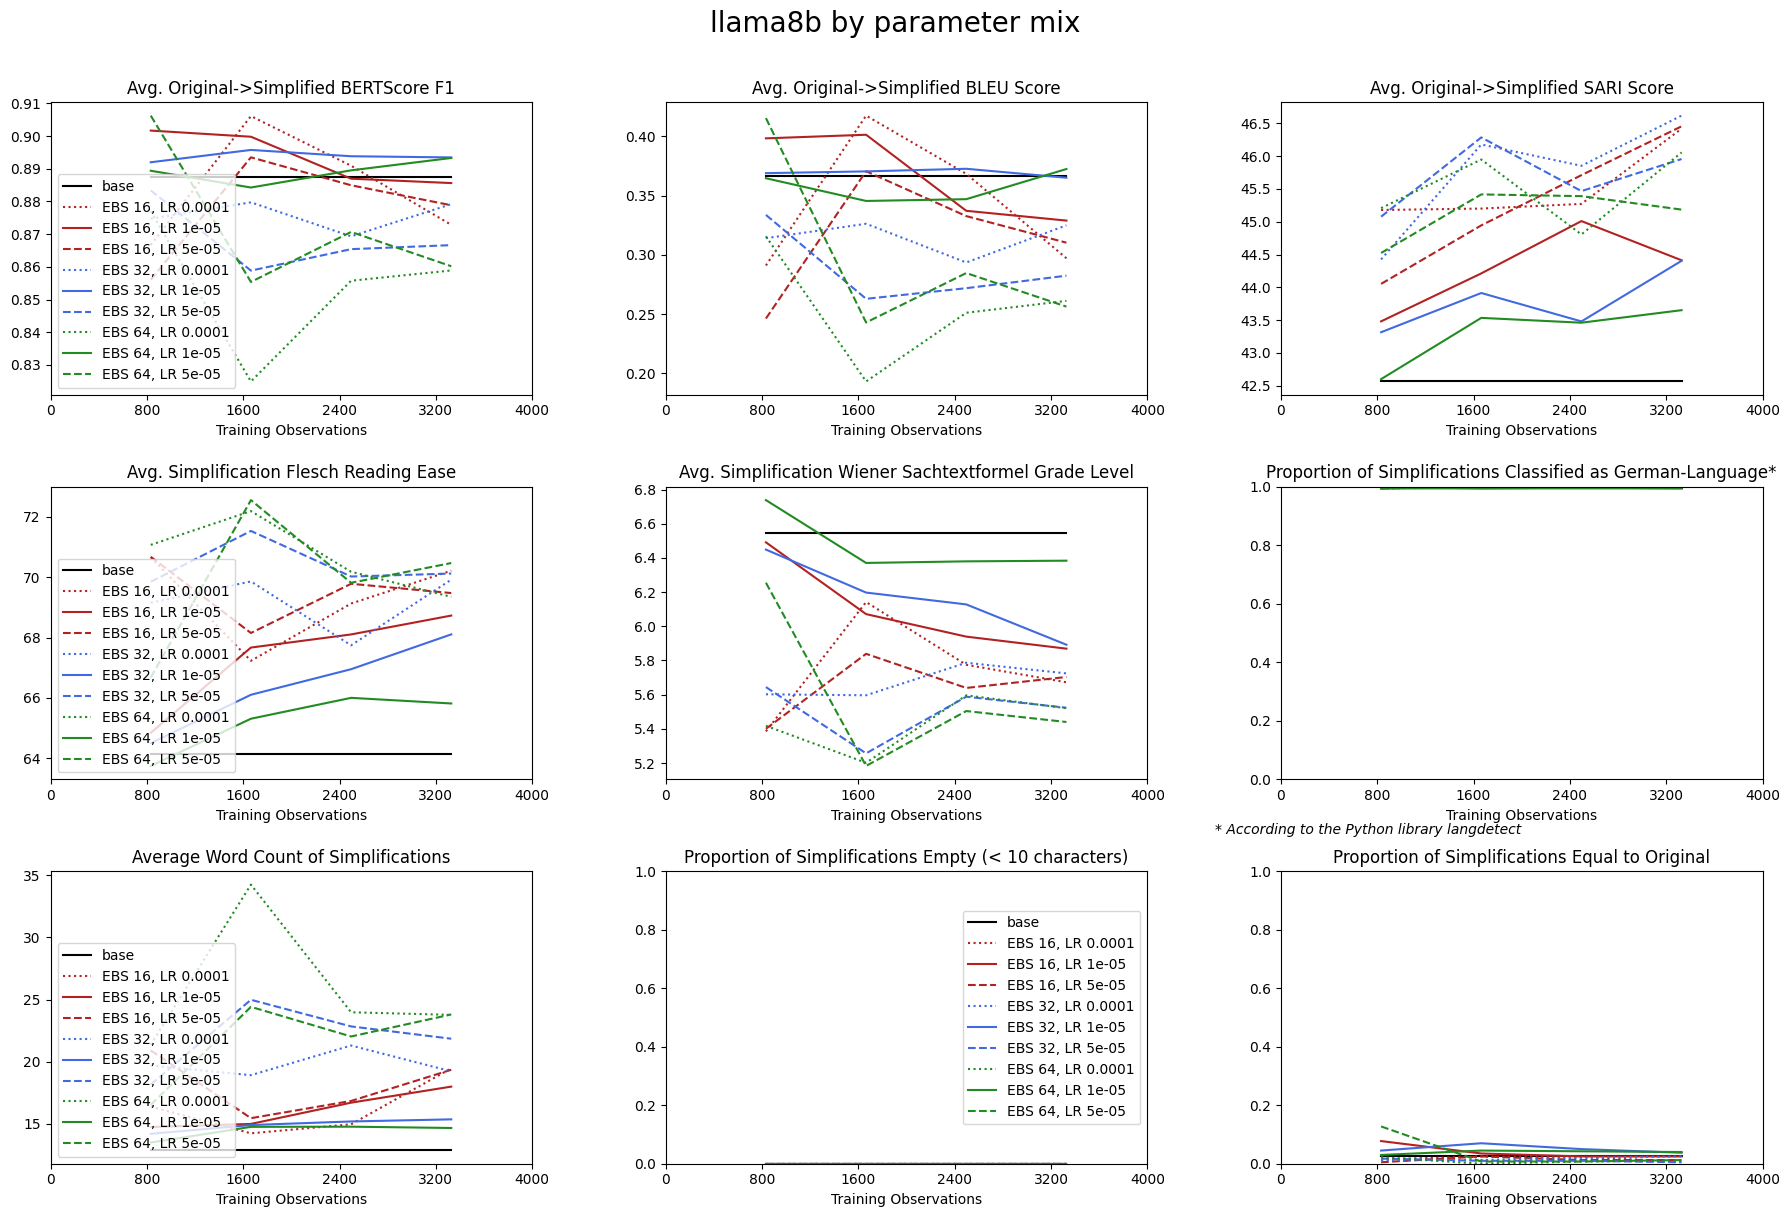

In [16]:
df_dict = sft_progression("cross_paramix", "llama8b", 832)
#print(df_dict)
plot_sft_progression("cross_paramix", "llama8b", df_dict)

cross_paramix


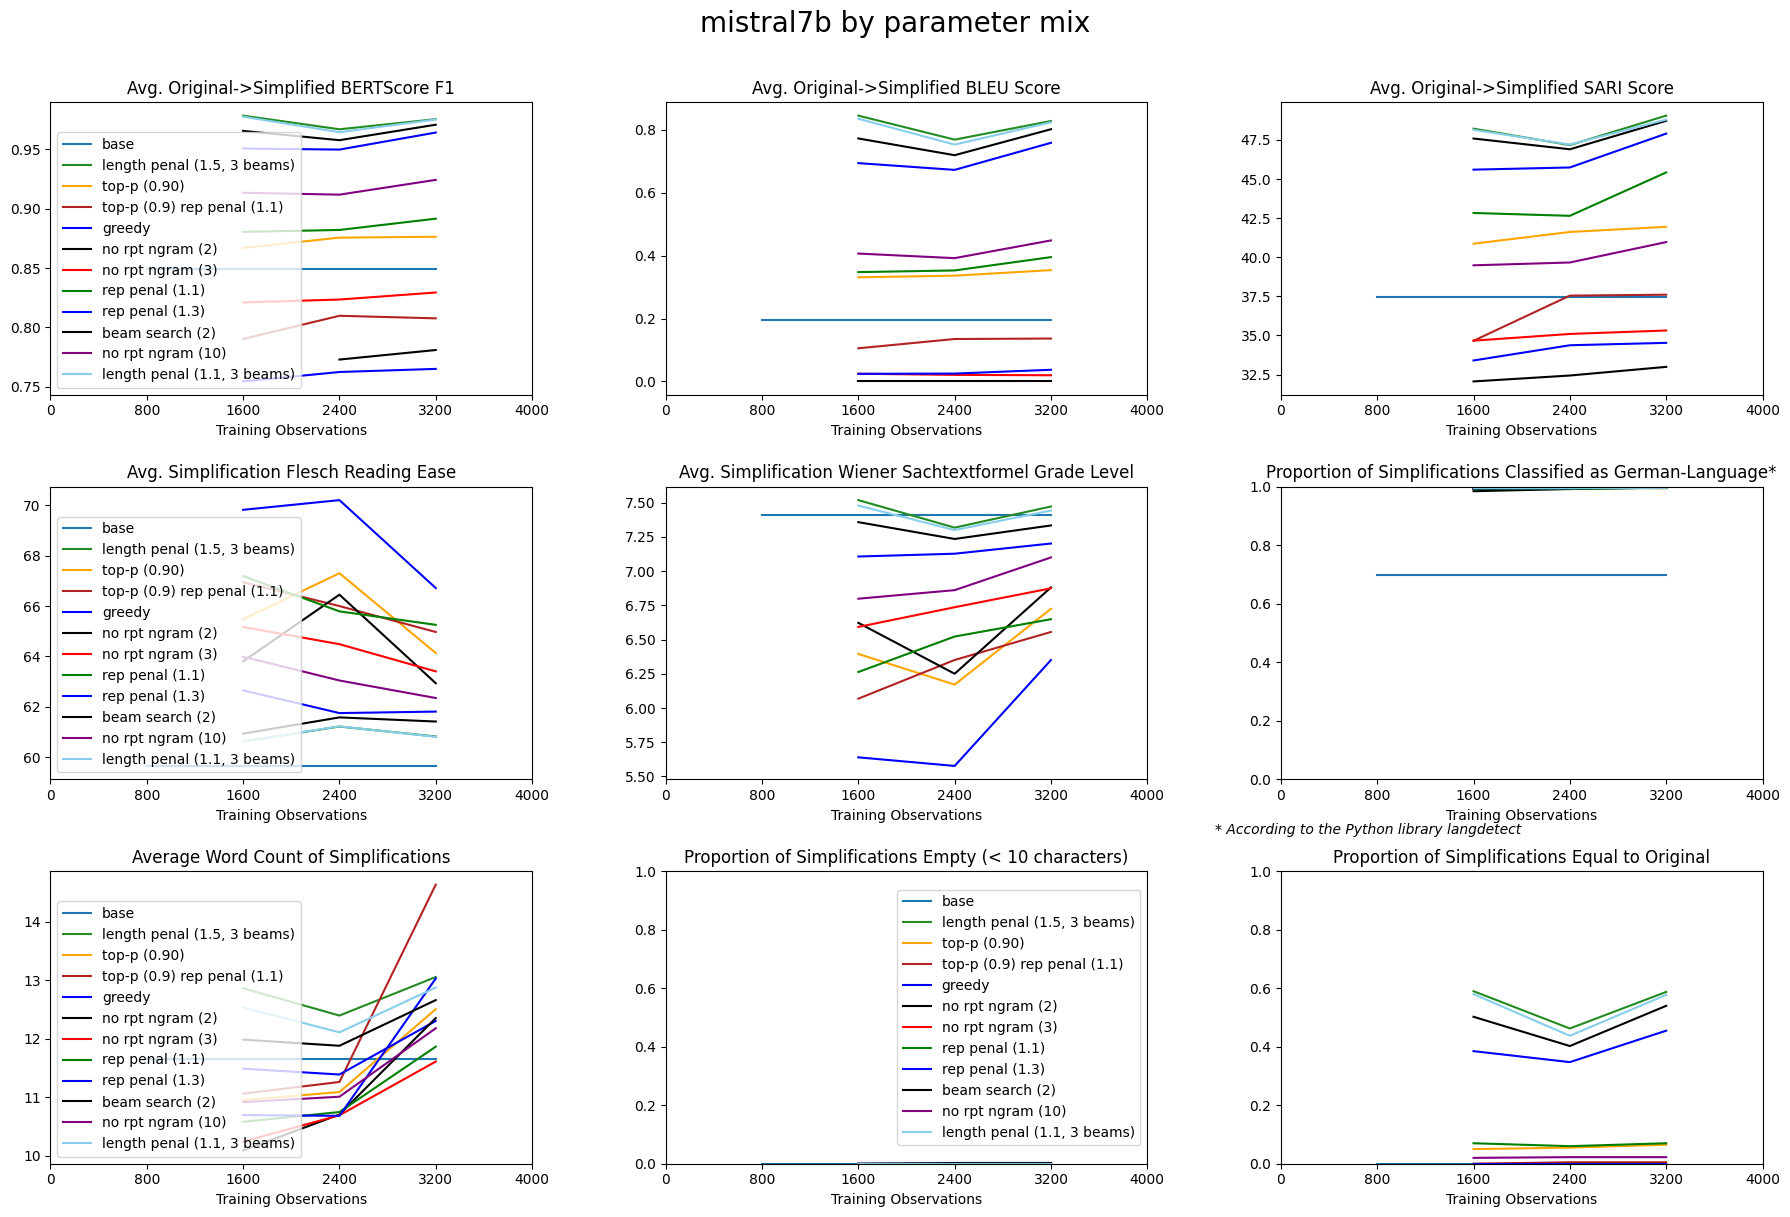

In [192]:
# Mistral7B: padding token during training should be unk, NOT eos. padding token during eval seems unimportant - but padding side is (left padding = more copies of original sentence and better eval on other metrics. right padding is opposite)

df_dict = sft_progression("cross_paramix", "mistral7b")
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop(columns=['bs2ga2dv2lr1e-4', 'bs2ga2dv2lr1e-5'])
plot_sft_progression("cross_paramix", "mistral7b", df_dict)

cross_paramix


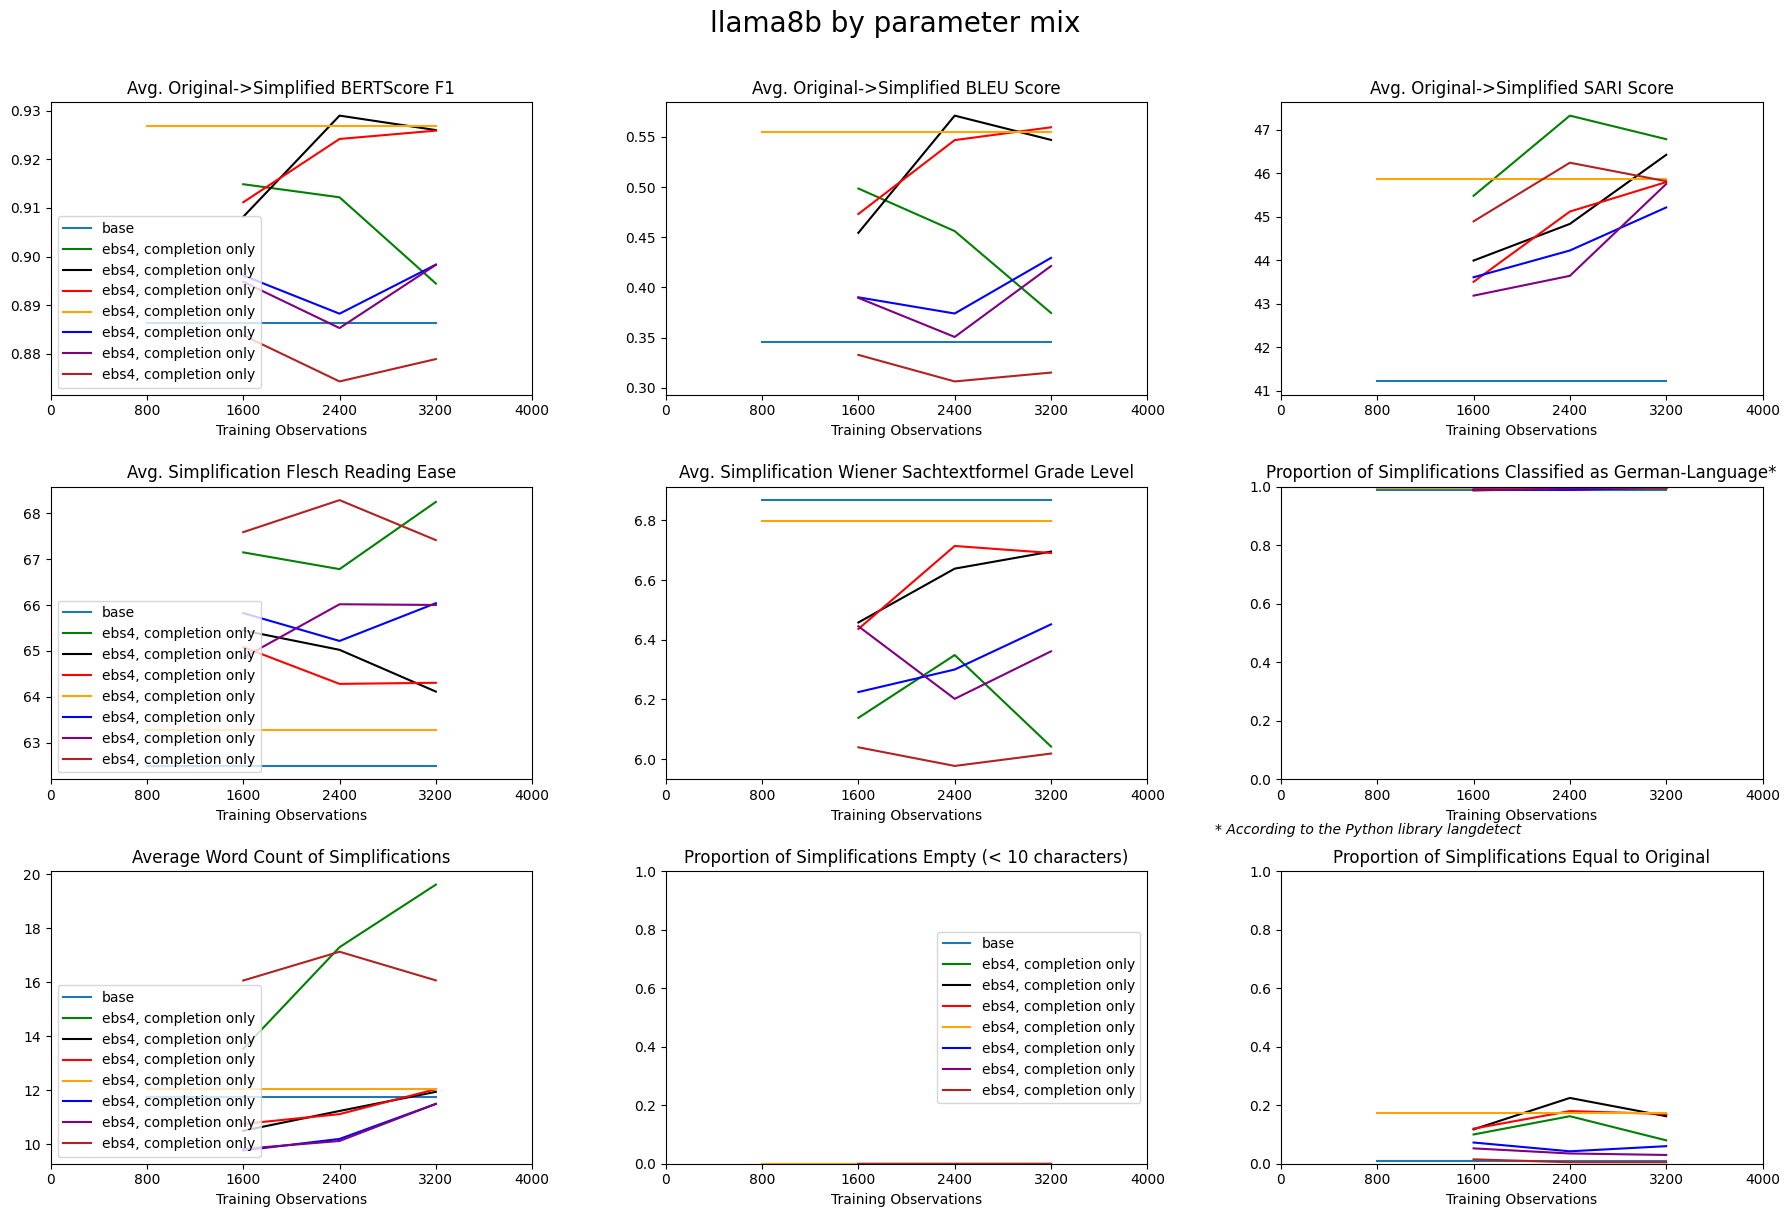

In [9]:
df_dict = sft_progression("cross_paramix", "llama8b")
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop(columns=['bs2ga2dv2lr1e-4', 'bs2ga2dv2lr1e-5'])
#print(df_dict)
plot_sft_progression("cross_paramix", "llama8b", df_dict)

cross_model


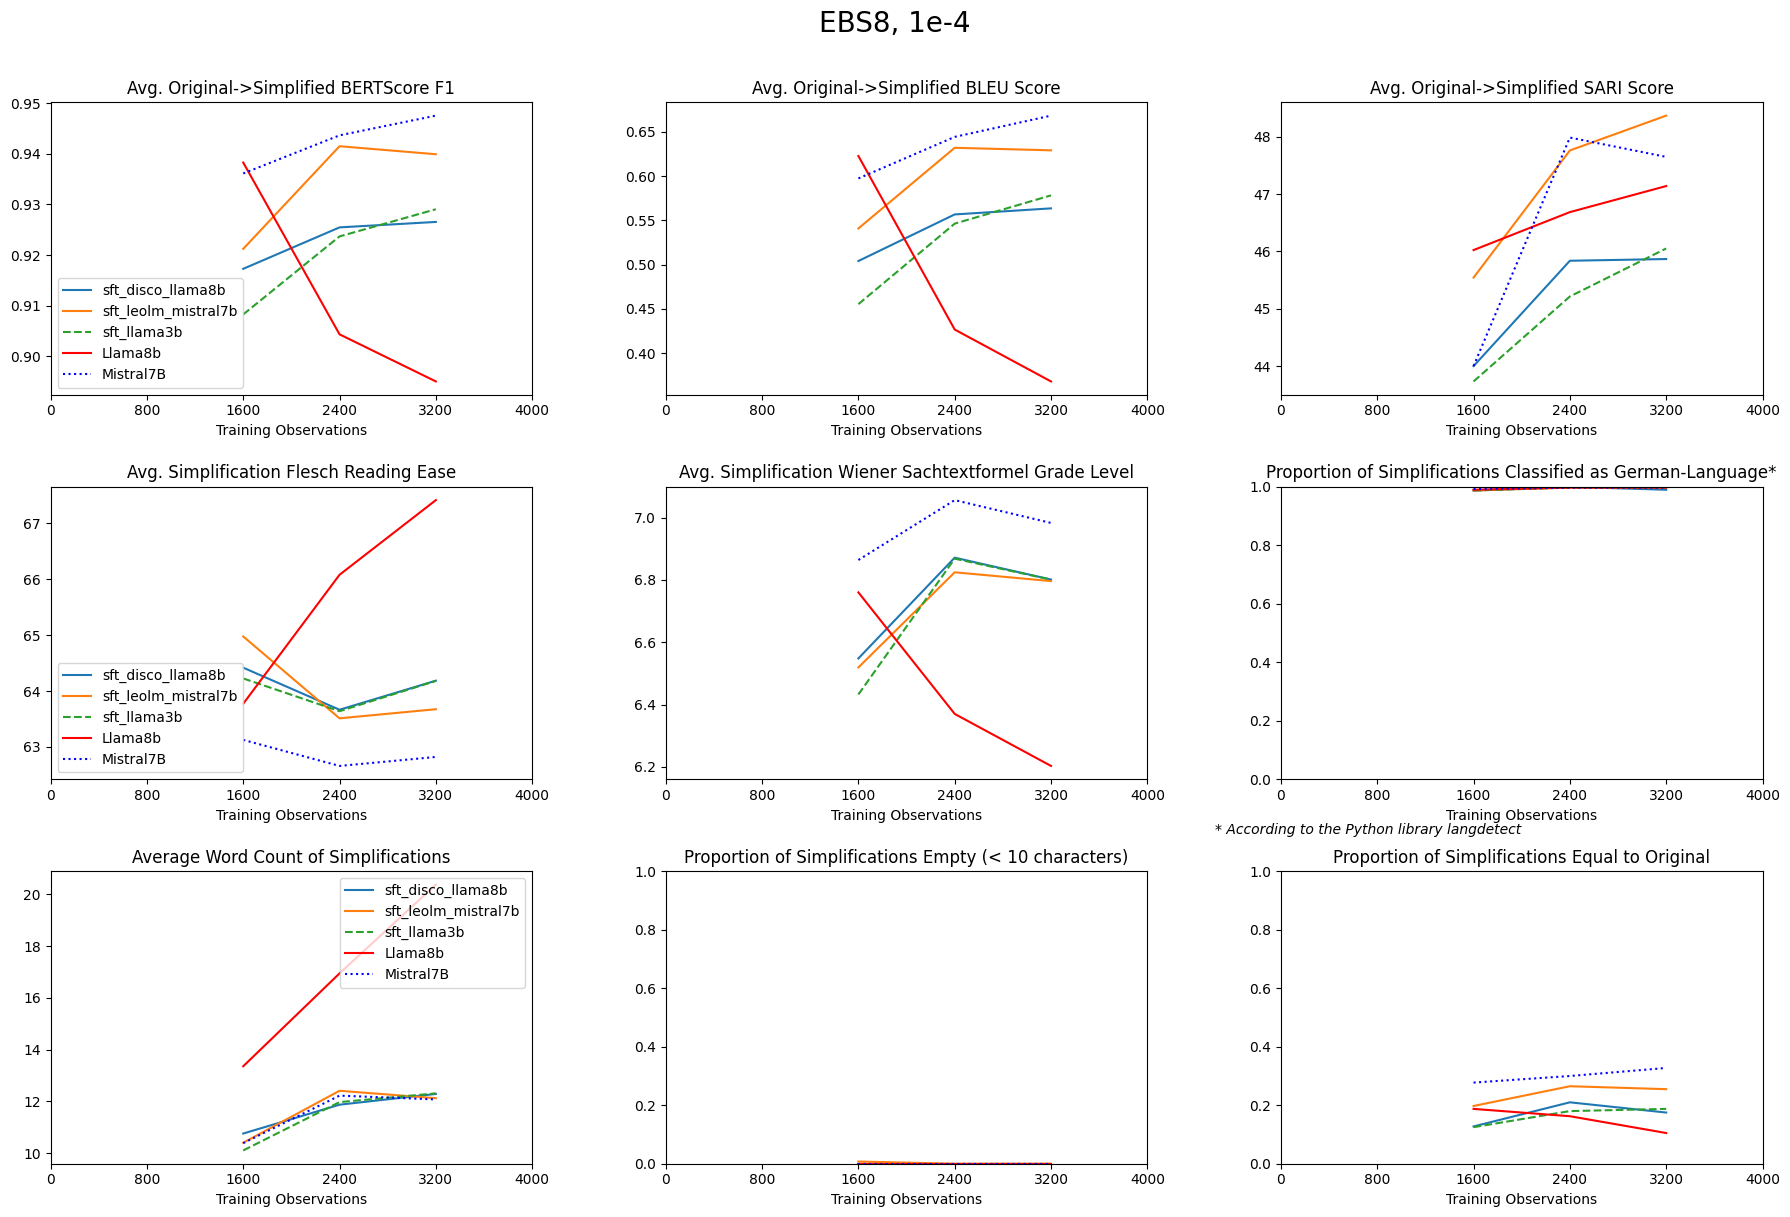

In [11]:
df_dict = sft_progression("cross_model", "bs2ga2dv2lr1e-4")
#print(df_dict)
plot_sft_progression("cross_model", "bs2ga2dv2lr1e-4", df_dict)

In [56]:
folder_path = 'outputs/holdout_eval/'
data = {}

for metric in metric_dfs:
    chosen_checkpoint = 3500
    checkpoint_values = metric_dfs[metric][metric_dfs[metric]['index'] == chosen_checkpoint].reset_index().drop(columns=['index'])
    for model in checkpoint_values.columns:
        if model != 'level_0' and 'sft' in model:
            if model not in data.keys():
                data[model] = {}
            data[model][metric] = checkpoint_values.iloc[0][model]

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index').sort_index(axis=0).sort_index(axis=1)
files = list(df.index)
files = sorted(files, key=lambda x: (x.replace("sft_", ""), "sft" in x))
df = df.reindex(files)
df = df[['bert', 'bleu', 'sari', 'ease', 'wstf', 'lang', 'loss']]
df = df.reindex(['sft_leolm_mistral7b', 'sft_mistral7b', 'sft_llama8b', 'sft_llama3b', 'sft_qwen7b', 'sft_qwen3b'])
df = df.round(3)
styled_df = df.style.apply(lambda x: ["font-weight: bold" if (
    (v == x.min() or v == x.nsmallest(2).iloc[-1]) and x.name in ['wstf', 'loss'])
    or
    (v == x.max() or v == x.nlargest(2).iloc[-1]) and x.name in ['bert', 'bleu', 'ease', 'sari', 'lang'] else "" for v in x], axis=0)

styled_df

NameError: name 'metric_dfs' is not defined

In [27]:
folder_path = 'outputs/holdout_eval/'
data = {}

for metric in metric_dfs:
    chosen_checkpoint = 3000
    checkpoint_values = metric_dfs[metric][metric_dfs[metric]['index'] == chosen_checkpoint].reset_index().drop(columns=['index'])
    for model in checkpoint_values.columns:
        if model != 'level_0' and 'sft' not in model:
            if model not in data.keys():
                data[model] = {}
            data[model][metric] = checkpoint_values.iloc[0][model]

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index').sort_index(axis=0).sort_index(axis=1)
files = list(df.index)
files = sorted(files, key=lambda x: (x.replace("sft_", ""), "sft" in x))
df = df.reindex(files)

styled_df = df.style.apply(lambda x: ["font-weight: bold" if (
    (v == x.min() or v == x.nsmallest(2).iloc[-1]) and x.name in ['wstf', 'loss'])
    or
    (v == x.max() or v == x.nlargest(2).iloc[-1]) and x.name in ['bert', 'bleu', 'ease', 'sari', 'lang'] else "" for v in x], axis=0)
styled_df

,bert,bleu,ease,lang,loss,sari,wstf
leolm_mistral7b,0.899931,0.436917,59.252512,0.992500,3.404970,41.490171,7.482125
llama3b,0.892107,0.387025,61.860350,0.991250,3.754200,41.311046,7.063250
llama8b,0.885500,0.315172,61.873812,0.987500,3.315145,41.645791,6.929625
qwen3b,0.846419,0.196828,63.080600,0.975000,3.642414,37.980781,6.502500
qwen7b,0.878886,0.290493,59.221038,0.976250,3.413154,40.519596,7.262375
